In [1]:
import torch
import pandas as pd
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
# from astropy.io import fits
import pdb
from scipy.ndimage.filters import maximum_filter1d
import glob
import fitsio as fits
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.distributions.normal import Normal
from tqdm import tqdm

In [2]:
import sys
sys.path.insert(0, '../')
sys.path.insert(1, '../latent_ode/')
import latent_ode.lib as ode
import latent_ode.lib.utils as utils
from latent_ode.lib.latent_ode import LatentODE
from latent_ode.lib.ode_rnn import ODE_RNN
from latent_ode.lib.encoder_decoder import Encoder_z0_ODE_RNN, Decoder
from latent_ode.lib.diffeq_solver import DiffeqSolver
from latent_ode.lib.ode_func import ODEFunc

In [5]:
from latent_rnn2d import create_LatentODE_model

In [6]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [7]:
# Options
input_dim = 2
classif_per_tp = False
n_labels = 1
obsrv_std = 0.1
niters = 1
status_properties = ['loss']
latent_dim = 40

In [8]:
model_file = 'latent_ode_state_gaia2d.pth.tar'

In [9]:
# state = torch.load('latent_ode_state.pth.tar')
state = torch.load(model_file, map_location=torch.device('cpu'))

In [10]:
# Model
obsrv_std = torch.Tensor([0.1]).to(device)
z0_prior = Normal(torch.Tensor([0.0]).to(device), torch.Tensor([1.]).to(device))
model = create_LatentODE_model(input_dim, z0_prior, obsrv_std).to(device)

In [11]:
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [12]:
model.eval()

LatentODE(
  (encoder_z0): Encoder_z0_ODE_RNN(
    (GRU_update): GRU_unit(
      (update_gate): Sequential(
        (0): Linear(in_features=104, out_features=100, bias=False)
        (1): Tanh()
        (2): Linear(in_features=100, out_features=50, bias=False)
        (3): Sigmoid()
      )
      (reset_gate): Sequential(
        (0): Linear(in_features=104, out_features=100, bias=False)
        (1): Tanh()
        (2): Linear(in_features=100, out_features=50, bias=False)
        (3): Sigmoid()
      )
      (new_state_net): Sequential(
        (0): Linear(in_features=104, out_features=100, bias=False)
        (1): Tanh()
        (2): Linear(in_features=100, out_features=100, bias=False)
      )
    )
    (z0_diffeq_solver): DiffeqSolver(
      (ode_func): ODEFunc(
        (gradient_net): Sequential(
          (0): Linear(in_features=50, out_features=100, bias=False)
          (1): Tanh()
          (2): Linear(in_features=100, out_features=100, bias=False)
          (3): Tanh()
       

### Plot Multiple

In [13]:
# loader = torch.load('toy_train.pt')
loader = torch.load('gaia2d_train.pt')

In [14]:
batch = next(iter(loader))

In [81]:
ix = 9


In [82]:
observed = batch['observed_data'][ix].unsqueeze(0).to(device)
true = batch['data_to_predict'][ix].unsqueeze(0).to(device)
mask = batch['observed_mask'][ix].unsqueeze(0).to(device)
t = batch['observed_tp'].to(device)

In [83]:
observed.shape

torch.Size([1, 39, 2])

In [84]:
rec = model.get_reconstruction(
    time_steps_to_predict=t, 
    truth=observed, 
    truth_time_steps=t, 
    mask=mask, 
    n_traj_samples=20)[0].detach().cpu().squeeze()

In [85]:
u = rec.mean(dim=0).detach().cpu().numpy()
recs = rec.detach().cpu().numpy()
truth = true.detach().squeeze().cpu().numpy()
obs = observed.squeeze().detach().cpu().numpy()
# t_obs = t[obs != 0]
# obs = obs[obs != 0]
# t = t.detach().cpu().numpy()

In [86]:
u1 = u[:,0]
u2 = u[:,1]
c1 = (obs[:,0] != 0)
c2 = (obs[:,1] != 0)

In [87]:
obs1 = obs[c1][:,0]
obs2 = obs[c2][:,1]
t1 = t[c1].detach().cpu().numpy()
t2 = t[c2].detach().cpu().numpy()

In [88]:
t0 = t.min()
g = t>t0

In [89]:
# https://matplotlib.org/examples/pylab_examples/fonts_demo.html

In [90]:
plt.style.use('seaborn-darkgrid')
# my_dpi=24
font = {'family': 'serif',
        'color':  'grey',
        'weight': 'light',
        'size': 12,
        }

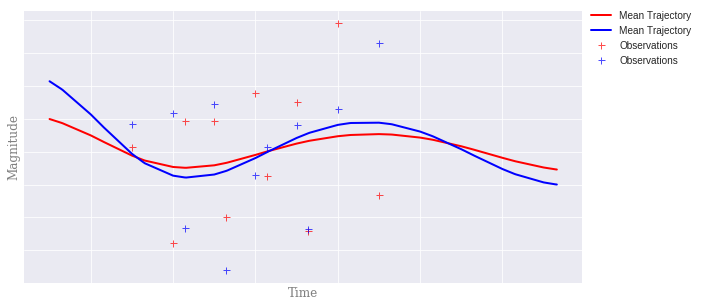

In [91]:
plt.figure(figsize=(10,5))
ax = plt.subplot(111)
# for i, r in enumerate(recs):
#     if i == 0:
#         ax.plot(t, r, marker='', color='grey', linewidth=1, alpha=0.4, label='Sampled Trajectories')
#     ax.plot(t, r, marker='', color='grey', linewidth=1, alpha=0.4)
ax.plot(t, u1, marker='', color='red', linewidth=2, alpha=1, label='Mean Trajectory')
ax.plot(t, u2, marker='', color='blue', linewidth=2, alpha=1, label='Mean Trajectory')
ax.plot(t1, obs1, marker='+', color='red', linestyle='None', alpha=0.7, markersize=7, label='Observations')
ax.plot(t2, obs2, marker='+', color='blue', linestyle='None', alpha=0.7, markersize=7, label='Observations')
plt.xlabel("Time", fontdict=font)
plt.ylabel("Magnitude", fontdict=font)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.9),
          ncol=1, fancybox=True, shadow=True)
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False,
    right=False, 
    left=False)